<a href="https://colab.research.google.com/github/chris-j-weber/MasterThesis/blob/main/Generate_Additional_Visual_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate additional visual features in the form of auto recognised faces (as png or csv)
(did not get into Thesis)

In [ ]:
import os
!rm -rf sample_data/
if not os.path.isfile('mmsd_raw_data.zip'):
  !gdown --id 1i9ixalVcXskA5_BkNnbR60sqJqvGyi6E

if not os.path.isdir('mmsd_raw_data'):
  !unzip -qq mmsd_raw_data.zip -d /content/mmsd_raw_data
  !rm -rf /content/mmsd_raw_data/__MACOSX/

!rm -rf sarcasmdetection
!git clone https://github.com/chris-j-weber/sarcasmdetection


Downloading...
From: https://drive.google.com/uc?id=1i9ixalVcXskA5_BkNnbR60sqJqvGyi6E
To: /content/mmsd_raw_data.zip
100% 1.40G/1.40G [00:12<00:00, 109MB/s]
Cloning into 'sarcasmdetection'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 99 (delta 45), reused 66 (delta 22), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [ ]:
# import libraries
!pip install face_recognition
import os
import cv2
import csv
import numpy as np
import face_recognition

faces_path = "./sarcasmdetection/data/faces/"
# Create arrays of known face encodings and their names
# all Characters appearing in BBT: ['SHELDON','PENNY','HOWARD','LEONARD','RAJ','PERSON','BERNADETTE','AMY','PERSON3','PERSON1']
# add all Characters from other shows as well
# TODO: extract appearing characters from dataset, use only those characers to avoid wrong recognition

filenames = os.listdir(faces_path)
known_face_names = []
known_face_encodings = []
print(filenames)

for fn in filenames:
    name, _ = os.path.splitext(fn)
    known_face_names.append(name)

    fn_path = faces_path + fn
    print(fn_path)
    fn_image = face_recognition.load_image_file(fn_path)
    fn_face_encoding = face_recognition.face_encodings(fn_image)[0]
    known_face_encodings.append(fn_face_encoding)


def extract_face_from_vid(file_path, outpath, write_img=True, write_csv=False):
    print(file_path)
    video_capture = cv2.VideoCapture(file_path)

    count = 0
    while True:
        # Initialize variables
        face_locations = []

        # Grab a single frame of video
        ret, frame = video_capture.read()

        if frame is None:
            continue
        count += 1

        # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
        rgb_frame = frame[:, :, ::-1]


        face_names = []
        face_encodings = []
        # Find all the faces in the current frame of video
        face_locations = face_recognition.face_locations(rgb_frame)
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

        for face_encoding in face_encodings:
            # See if the face is a match for the known face(s)
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"
            # Or instead, use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)

        if len(face_locations)>0:
            for i, face in enumerate(face_locations):
                #openmouth = check_mouth_open(face['top_lip'], face['bottom_lip'])

                # Display the results
                top, right, bottom, left = face_locations[i]

                width, height = 256, 256
                dim = (width, height)
                face_frame = frame[top:bottom, left:right]
                resized = cv2.resize(face_frame, dim, interpolation=cv2.INTER_AREA)
                gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

                data = np.array(gray.ravel()).tolist()
                data = ' '.join([str(i) for i in data])

                # write images into named subfolders
                if write_img:
                  image_outpath = os.path.join(outpath, face_names[i])
                  os.makedirs(image_outpath, exist_ok=True)
                  image_outpath = os.path.join(image_outpath, str(count) + '.png')
                  cv2.imwrite(image_outpath, gray)

                #instead write into csv
                if write_csv:
                  with open(outpath + '.csv', mode='a', newline='') as csv_file:
                      fieldnames = ['is_sarcastic','pixels']
                      writer = csv.DictWriter(csv_file, fieldnames=fieldnames, delimiter=',')
                      writer.writerow({'is_sarcastic': 1,'pixels': data})

                # Draw a box around the face
                #cv2.rectangle(gray, (left, top), (right, bottom), (0, 0, 255), 2)
                #cv2.putText(gray, str(openmouth), (right-left, bottom), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

                # Display the resulting image
                #cv2.imshow('Video', gray)


    # Release handle to the webcam
    video_capture.release()
    cv2.destroyAllWindows()


['PENNY.jpg', 'LEONARD.jpg', 'AMY.jpg', 'HOWARD.jpg', 'BERNADETTE.jpg', 'RAJ.jpg', 'SHELDON.jpg']
./sarcasmdetection/data/faces/PENNY.jpg
./sarcasmdetection/data/faces/LEONARD.jpg
./sarcasmdetection/data/faces/AMY.jpg
./sarcasmdetection/data/faces/HOWARD.jpg
./sarcasmdetection/data/faces/BERNADETTE.jpg
./sarcasmdetection/data/faces/RAJ.jpg
./sarcasmdetection/data/faces/SHELDON.jpg


In [ ]:
write_output_as_img = False #@param {type:"boolean"}
write_output_as_csv = True #@param {type:"boolean"}



videoDir = "./mmsd_raw_data/utterances_final"
outDir = "./data_out/"

for i, filename in enumerate(os.listdir(videoDir)):
    f = os.path.join(videoDir, filename)
    filehead, _ =  os.path.splitext(filename)
    # checking if it is a file
    print(filehead)
    if os.path.isfile(f):

        print(f)
        print(filehead)
        #outpath = os.path.join(outpath, filename[:-4]) + '.csv'

        #create new dir
        image_outpath = outDir + filehead
        print(f)
        print(image_outpath)

        os.makedirs(image_outpath, exist_ok=True)

        extract_face_from_vid(f, image_outpath, write_img=write_output_as_img, write_csv=write_output_as_csv)

217
(256, 256, 3)


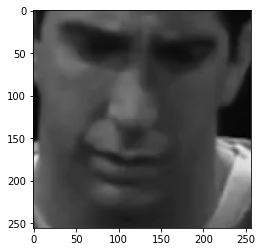

In [ ]:
#@title check if csv is correct

import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("./data_out/2_541.csv", delimiter=',', names=['is_sarcastic', 'pixels'])

print(len(df))

X = df['pixels'][0]

features = np.fromstring(X, np.float32, sep=' ')
features = np.stack((features,) * 3, axis=-1)
features /= 255

y = features.reshape(256,256,3)
print(y.shape)

plt.imshow(y)
plt.show()